1a) Created Dataset from mnist dataset then Loads a 3D point cloud from an HDF5 file.
Converts it into a 3D voxel grid
Transforms the voxel grid into a PyTorch tensor.
Applies 3D convolution to extract features from the voxel data.
Processes the data through an activation function (
Outputs a new voxel feature tensor for further processing.

---



✅ Using group: 0
Voxel Grid Shape: (16, 16, 16)


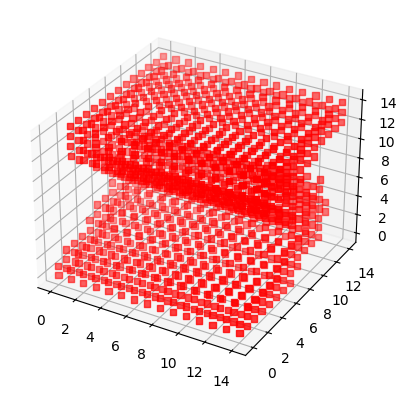

Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 1, 16, 16, 16])


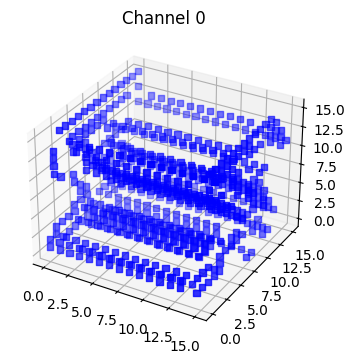

In [ ]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------- Load HDF5 Point Cloud Data -------------------- #
def load_h5_point_clouds(file_path, voxel_size=(16, 16, 16)):
    """Loads one point cloud sample from an HDF5 file and converts it to a voxel grid."""
    with h5py.File(file_path, 'r') as f:
        groups = list(f.keys())  # Get all groups

        # Find the first group containing "points"
        selected_group = None
        for group_name in groups:
            if "points" in f[group_name]:
                selected_group = group_name
                break

        if selected_group is None:
            raise ValueError("No valid point cloud dataset found in HDF5 file.")

        print(f"✅ Using group: {selected_group}")

        # Extract point cloud
        points = np.array(f[selected_group]["points"], dtype=np.float32)  # Ensure numeric

        # Convert point cloud to voxel grid
        voxel_grid = point_cloud_to_voxel(points, voxel_size)

        return voxel_grid

# -------------------- Point Cloud to Voxel Conversion -------------------- #
def point_cloud_to_voxel(points, grid_size=(16, 16, 16)):
    """Converts a point cloud into a voxel grid representation."""
    voxel_grid = np.zeros(grid_size, dtype=np.float32)

    # Normalize points to range [0,1]
    min_vals = points.min(axis=0)
    max_vals = points.max(axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals + 1e-6)

    # Convert to voxel indices
    indices = (normalized_points * (np.array(grid_size) - 1)).astype(int)

    # Fill the voxel grid
    for x, y, z in indices:
        voxel_grid[x, y, z] = 1.0  # Mark occupied voxels

    return voxel_grid

# -------------------- Convert Voxel Grid to PyTorch Tensor -------------------- #
def pointcloud_to_tensor(points, voxel_size=32):
    voxel_grid = np.zeros((voxel_size, voxel_size, voxel_size), dtype=np.float32)
    indices = (points * (voxel_size - 1)).astype(int)
    voxel_grid[indices[:, 0], indices[:, 1], indices[:, 2]] = 1.0
    return torch.tensor(voxel_grid).unsqueeze(0).unsqueeze(0)  # Shape (1,1,D,H,W)

# -------------------- Visualize Voxel Grid -------------------- #
def visualize_voxel_grid(voxel_grid):
    """Plots the voxelized representation of the point cloud."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    filled_voxels = np.argwhere(voxel_grid.numpy().squeeze() > 0)
    ax.scatter(filled_voxels[:, 0], filled_voxels[:, 1], filled_voxels[:, 2], c='r', marker='s')
    plt.show()

# -------------------- Apply 3D Convolution -------------------- #
def manual_conv3d(input_tensor, weight, bias=None, stride=1, padding=1):
    """Manually implements 3D convolution."""
    batch_size, in_channels, D, H, W = input_tensor.shape
    out_channels, _, kernel_D, kernel_H, kernel_W = weight.shape

    out_D = (D - kernel_D + 2 * padding) // stride + 1
    out_H = (H - kernel_H + 2 * padding) // stride + 1
    out_W = (W - kernel_W + 2 * padding) // stride + 1

    padded_input = torch.nn.functional.pad(input_tensor, (padding, padding, padding, padding, padding, padding))
    output = torch.zeros((batch_size, out_channels, out_D, out_H, out_W))

    for oc in range(out_channels):
        for ic in range(in_channels):
            for d in range(out_D):
                for h in range(out_H):
                    for w in range(out_W):
                        region = padded_input[:, ic, d*stride:d*stride+kernel_D, h*stride:h*stride+kernel_H, w*stride:w*stride+kernel_W]
                        output[:, oc, d, h, w] += torch.sum(region * weight[oc, ic])
        if bias is not None:
            output[:, oc] += bias[oc]
    return output

def apply_3d_convolution(input_tensor, out_channels=8, kernel_size=3, stride=1, padding=1, activation='relu'):
    """Applies 3D convolution to the given input tensor with specified parameters."""
    in_channels = input_tensor.shape[1]
    weight = torch.randn((out_channels, in_channels, kernel_size, kernel_size, kernel_size))
    bias = torch.randn(out_channels)
    output_tensor = manual_conv3d(input_tensor, weight, bias, stride, padding)

    if activation == 'relu':
        output_tensor = torch.relu(output_tensor)
    elif activation == 'sigmoid':
        output_tensor = torch.sigmoid(output_tensor)
    elif activation == 'tanh':
        output_tensor = torch.tanh(output_tensor)
    elif activation == 'leaky_relu':
        output_tensor = torch.nn.functional.leaky_relu(output_tensor)
    else:
        raise ValueError("Unsupported activation function")

    print("Input Tensor Shape:", input_tensor.shape)
    print("Output Tensor Shape:", output_tensor.shape)
    return output_tensor

# -------------------- Visualize Activation Maps -------------------- #
def visualize_all_activation_maps(output_tensor):
    """Visualizes all activation map channels in separate subplots."""
    activation_map = output_tensor.detach().numpy().squeeze()

    # Ensure activation_map is at least 3D (C, D, H, W)
    if activation_map.ndim == 3:
        activation_map = np.expand_dims(activation_map, axis=0)  # Add channel axis

    num_channels = activation_map.shape[0]

    fig, axes = plt.subplots(1, num_channels, figsize=(num_channels * 4, 4), subplot_kw={'projection': '3d'})

    # Handle case where num_channels is 1 (avoid indexing issues)
    if num_channels == 1:
        axes = [axes]

    for i in range(num_channels):
        nonzero_voxels = np.argwhere(activation_map[i] > 0)
        axes[i].scatter(nonzero_voxels[:, 0], nonzero_voxels[:, 1], nonzero_voxels[:, 2], c='b', marker='s')
        axes[i].set_title(f'Channel {i}')

    plt.show()

# -------------------- Run the Pipeline -------------------- #
if __name__ == "__main__":
    # Load a sample point cloud from HDF5
    voxel_sample = load_h5_point_clouds("/content/train_point_clouds.h5")

    print(f"Voxel Grid Shape: {voxel_sample.shape}")  # Expected: (16, 16, 16)

    # Convert to PyTorch tensor
    voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)  # Shape: (1,1,16,16,16)

    # Visualize voxel grid
    visualize_voxel_grid(voxel_tensor)

    # Apply 3D convolution
    output_tensor = apply_3d_convolution(voxel_tensor, out_channels=1, kernel_size=3, stride=1, padding=1, activation='relu')

    # Visualize activation maps
    visualize_all_activation_maps(output_tensor)


Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 1, 13, 13, 13])


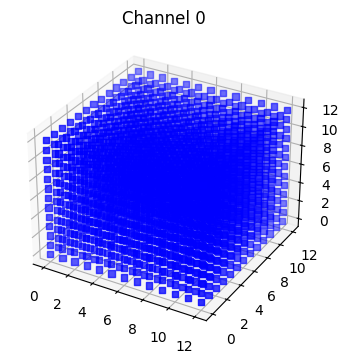

In [ ]:
voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)
output_tensor= apply_3d_convolution(voxel_tensor, out_channels=1, kernel_size=6, stride=1, padding=1, activation='sigmoid')

# Visualize all activation map channels
visualize_all_activation_maps(output_tensor)

Input Tensor Shape: torch.Size([1, 2, 28, 28, 28])
Output Tensor Shape: torch.Size([1, 1, 28, 28, 28])


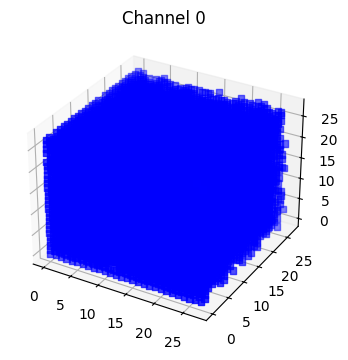

In [ ]:
custom_tensor = torch.rand(1, 2, 28, 28, 28)  # Batch=1, Channels=2, Depth=28, Height=28, Width=28 customize input tensor
output_tensor = apply_3d_convolution(custom_tensor, out_channels=1, kernel_size=3, stride=1, padding=1, activation='tanh')
visualize_all_activation_maps(output_tensor)


*1b*) created maxpool and average pooling function

In [ ]:
def apply_3d_convolution(input_tensor, out_channels=8, kernel_size=3, stride=1, padding=1, activation='relu'):
    """Applies 3D convolution to the given input tensor with specified parameters."""
    in_channels = input_tensor.shape[1]
    weight = torch.randn((out_channels, in_channels, kernel_size, kernel_size, kernel_size))
    bias = torch.randn(out_channels)
    output_tensor = manual_conv3d(input_tensor, weight, bias, stride, padding)

    if activation == 'relu':
        output_tensor = torch.relu(output_tensor)
    elif activation == 'sigmoid':
        output_tensor = torch.sigmoid(output_tensor)
    elif activation == 'tanh':
        output_tensor = torch.tanh(output_tensor)
    elif activation == 'leaky_relu':
        output_tensor = torch.nn.functional.leaky_relu(output_tensor)
    else:
        raise ValueError("Unsupported activation function")

    print("Input Tensor Shape:", input_tensor.shape)
    print("Output Tensor Shape:", output_tensor.shape)
    return output_tensor

def max_pool3d(input_tensor, kernel_size=2, stride=2):
    """Manually applies 3D Max Pooling."""
    _, C, D, H, W = input_tensor.shape
    out_D = (D - kernel_size) // stride + 1
    out_H = (H - kernel_size) // stride + 1
    out_W = (W - kernel_size) // stride + 1

    pooled_output = torch.zeros((1, C, out_D, out_H, out_W))
    for c in range(C):
        for d in range(out_D):
            for h in range(out_H):
                for w in range(out_W):
                    pooled_output[:, c, d, h, w] = torch.max(
                        input_tensor[:, c, d*stride:d*stride+kernel_size, h*stride:h*stride+kernel_size, w*stride:w*stride+kernel_size]
                    )
    return pooled_output

def avg_pool3d(input_tensor, kernel_size=2, stride=2):
    """Manually applies 3D Average Pooling."""
    _, C, D, H, W = input_tensor.shape
    out_D = (D - kernel_size) // stride + 1
    out_H = (H - kernel_size) // stride + 1
    out_W = (W - kernel_size) // stride + 1

    pooled_output = torch.zeros((1, C, out_D, out_H, out_W))
    for c in range(C):
        for d in range(out_D):
            for h in range(out_H):
                for w in range(out_W):
                    pooled_output[:, c, d, h, w] = torch.mean(
                        input_tensor[:, c, d*stride:d*stride+kernel_size, h*stride:h*stride+kernel_size, w*stride:w*stride+kernel_size]
                    )
    return pooled_output

def compare_pooling_methods(output_tensor, kernel_size=2, stride=2):
    """Compares Max Pooling and Average Pooling on the given activation map."""
    pooled_max = max_pool3d(output_tensor, kernel_size, stride)
    pooled_avg = avg_pool3d(output_tensor, kernel_size, stride)

    print("Max Pooled Shape:", pooled_max.shape)
    print("Avg Pooled Shape:", pooled_avg.shape)

    visualize_all_activation_maps(pooled_max.squeeze(0))
    visualize_all_activation_maps(pooled_avg.squeeze(0))


Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 1, 9, 9, 9])
Max Pooled Shape: torch.Size([1, 1, 6, 6, 6])
Avg Pooled Shape: torch.Size([1, 1, 6, 6, 6])


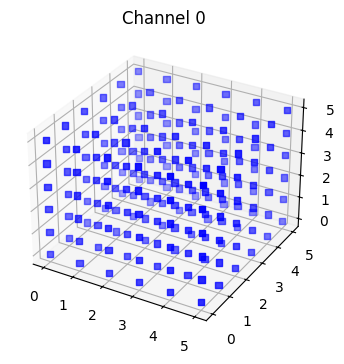

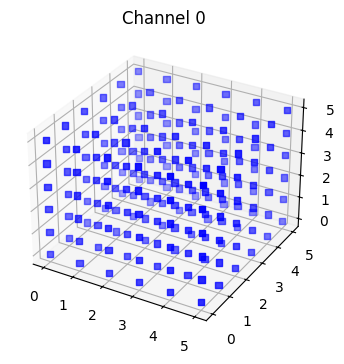

In [ ]:
voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)
output_tensor = apply_3d_convolution(voxel_tensor, out_channels=1, kernel_size=2, stride=2, padding=1, activation='sigmoid')

# Compare pooling methods multiple channels becacuse of feature retention mention in question
compare_pooling_methods(output_tensor, kernel_size=4, stride=1)

Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Max Pooled Shape: torch.Size([1, 1, 8, 8, 8])
Avg Pooled Shape: torch.Size([1, 1, 8, 8, 8])


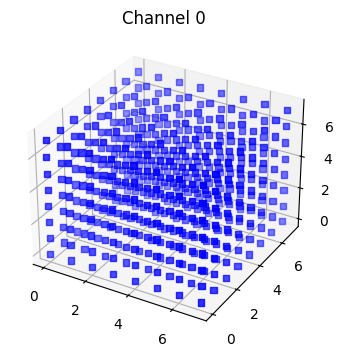

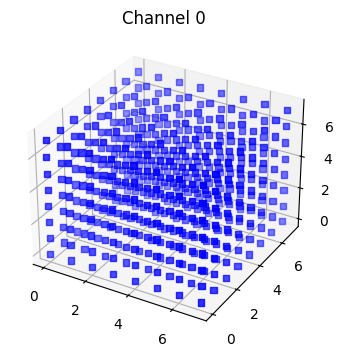

In [ ]:

output_tensor = apply_3d_convolution(voxel_tensor, out_channels=1, kernel_size=3, stride=1, padding=1, activation='relu')

# Compare pooling methods
compare_pooling_methods(output_tensor, kernel_size=2, stride=2)

Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Max Pooled Shape: torch.Size([1, 1, 8, 8, 8])
Avg Pooled Shape: torch.Size([1, 1, 8, 8, 8])


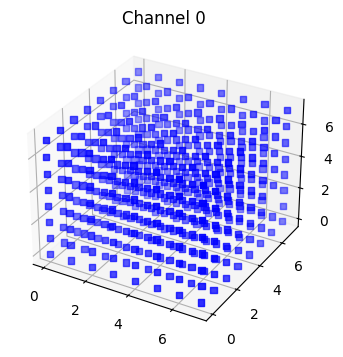

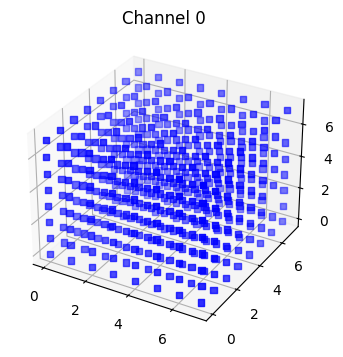

In [ ]:
output_tensor = apply_3d_convolution(voxel_tensor, out_channels=1, kernel_size=3, stride=1, padding=1, activation='leaky_relu')

# Compare pooling methods
compare_pooling_methods(output_tensor, kernel_size=2, stride=2)

Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Max Pooled Shape: torch.Size([1, 1, 8, 8, 8])
Avg Pooled Shape: torch.Size([1, 1, 8, 8, 8])


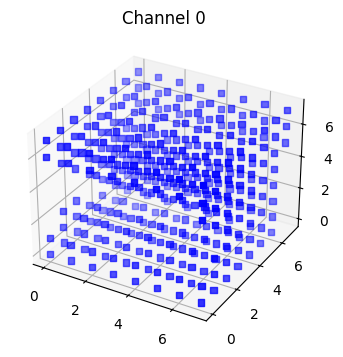

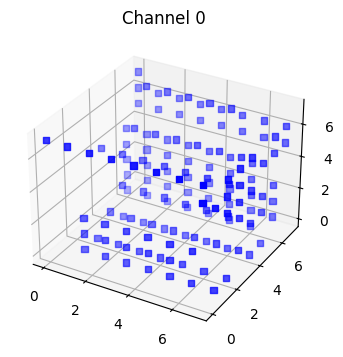

In [ ]:
voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)
output_tensor = apply_3d_convolution(voxel_tensor, out_channels=1, kernel_size=3, stride=1, padding=1, activation='tanh')

# Compare pooling methods
compare_pooling_methods(output_tensor, kernel_size=2, stride=2)


# 1c) multiple output channel

Kernel Shape: torch.Size([4, 1, 3, 3, 3])
Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 4, 16, 16, 16])


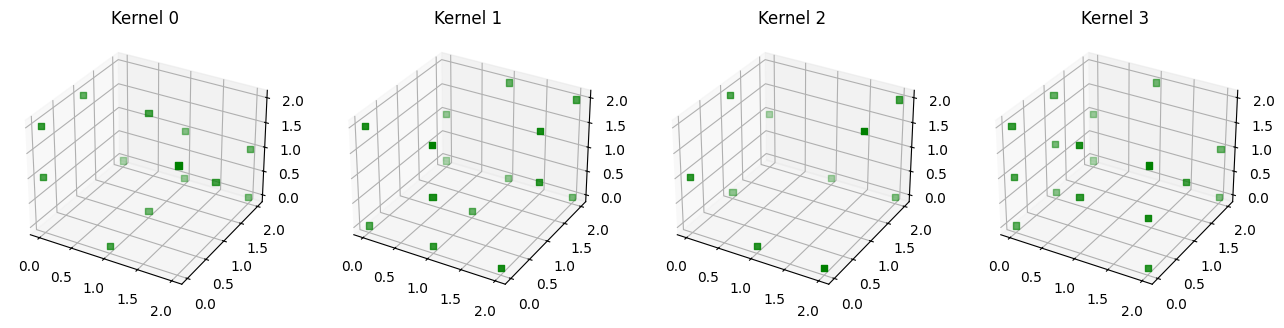

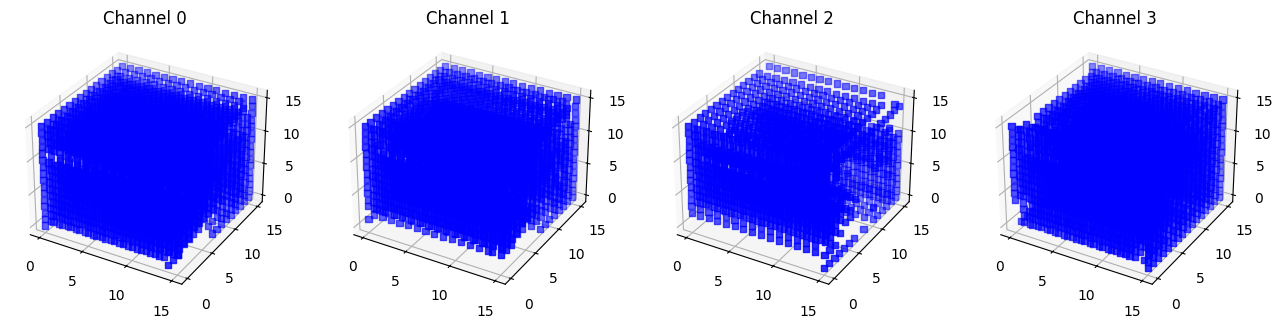

In [ ]:
def apply_3d_convolution(input_tensor, out_channels=8, kernel_size=3, stride=1, padding=1, activation='relu'):
    """Applies 3D convolution to the given input tensor with specified parameters."""
    in_channels = input_tensor.shape[1]
    weight = torch.randn((out_channels, in_channels, kernel_size, kernel_size, kernel_size))
    bias = torch.randn(out_channels)

    print("Kernel Shape:", weight.shape)
    output_tensor = manual_conv3d(input_tensor, weight, bias, stride, padding)

    if activation == 'relu':
        output_tensor = torch.relu(output_tensor)
    elif activation == 'sigmoid':
        output_tensor = torch.sigmoid(output_tensor)
    elif activation == 'tanh':
        output_tensor = torch.tanh(output_tensor)
    elif activation == 'leaky_relu':
        output_tensor = torch.nn.functional.leaky_relu(output_tensor)
    else:
        raise ValueError("Unsupported activation function")

    print("Input Tensor Shape:", input_tensor.shape)
    print("Output Tensor Shape:", output_tensor.shape)
    return output_tensor,weight
def visualize_kernels(weight):
    """Visualizes each 3D kernel in separate subplots."""
    out_channels, in_channels, kernel_D, kernel_H, kernel_W = weight.shape

    fig, axes = plt.subplots(1, out_channels, figsize=(out_channels * 4, 4), subplot_kw={'projection': '3d'})
    if out_channels == 1:
        axes = [axes]  # Ensure iterable

    weight_np = weight.detach().numpy()

    for oc in range(out_channels):
        kernel = weight_np[oc, 0]  # Take the first input channel
        nonzero_voxels = np.argwhere(kernel > 0)  # Find nonzero values
        axes[oc].scatter(nonzero_voxels[:, 0], nonzero_voxels[:, 1], nonzero_voxels[:, 2], c='g', marker='s')
        axes[oc].set_title(f'Kernel {oc}')

    plt.show()

# Apply 3D convolution and get kernel
output_tensor, kernel_weights = apply_3d_convolution(voxel_tensor, out_channels=4, kernel_size=3, stride=1, padding=1, activation='relu')

# Visualize kernels
visualize_kernels(kernel_weights)

# Visualize activation maps
visualize_all_activation_maps(output_tensor)


Kernel Shape: torch.Size([4, 1, 3, 3, 3])
Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 4, 9, 9, 9])


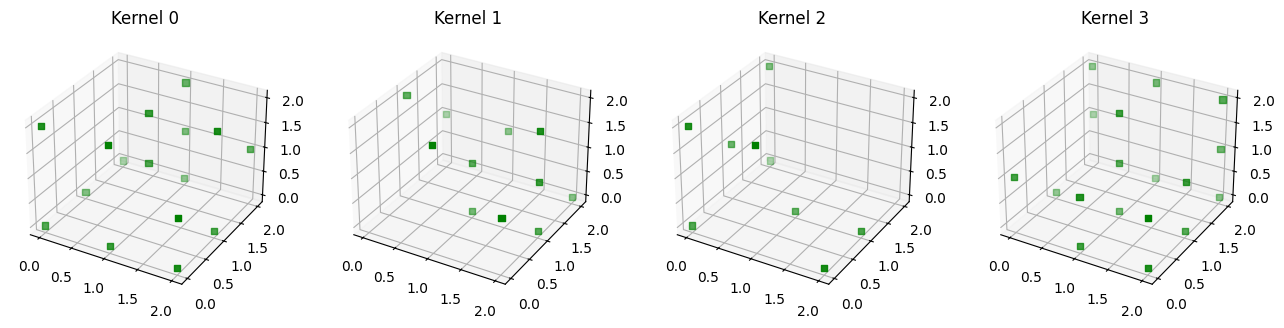

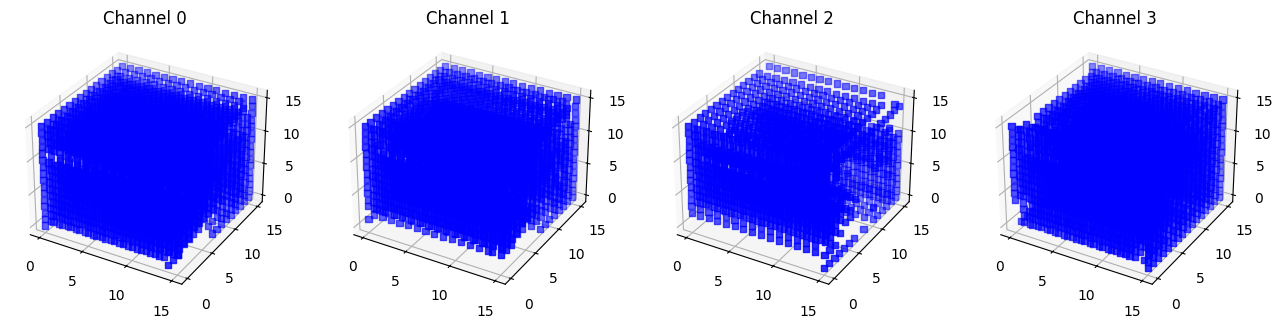

In [ ]:
output_tensor, kernel_weights = apply_3d_convolution(voxel_tensor, out_channels=4, kernel_size=3, stride=2, padding=2, activation='relu')

# Visualize kernels
visualize_kernels(kernel_weights)

# Visualize activation maps
visualize_all_activation_maps(output_tensor)

**1d)**GAP layer average of feature map
Max pooling preserves prominent features by selecting the highest value, while average pooling smooths the representation by computing mean values, reducing spatial detail. Global average pooling further compresses features into a single value per channel, emphasizing overall feature presence rather than spatial relationships.

Kernel Shape: torch.Size([8, 1, 3, 3, 3])
Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 8, 16, 16, 16])
Max Pooled Shape: torch.Size([1, 8, 8, 8, 8])
Avg Pooled Shape: torch.Size([1, 8, 8, 8, 8])
Global Avg Pooled Shape: torch.Size([1, 8, 1, 1, 1])


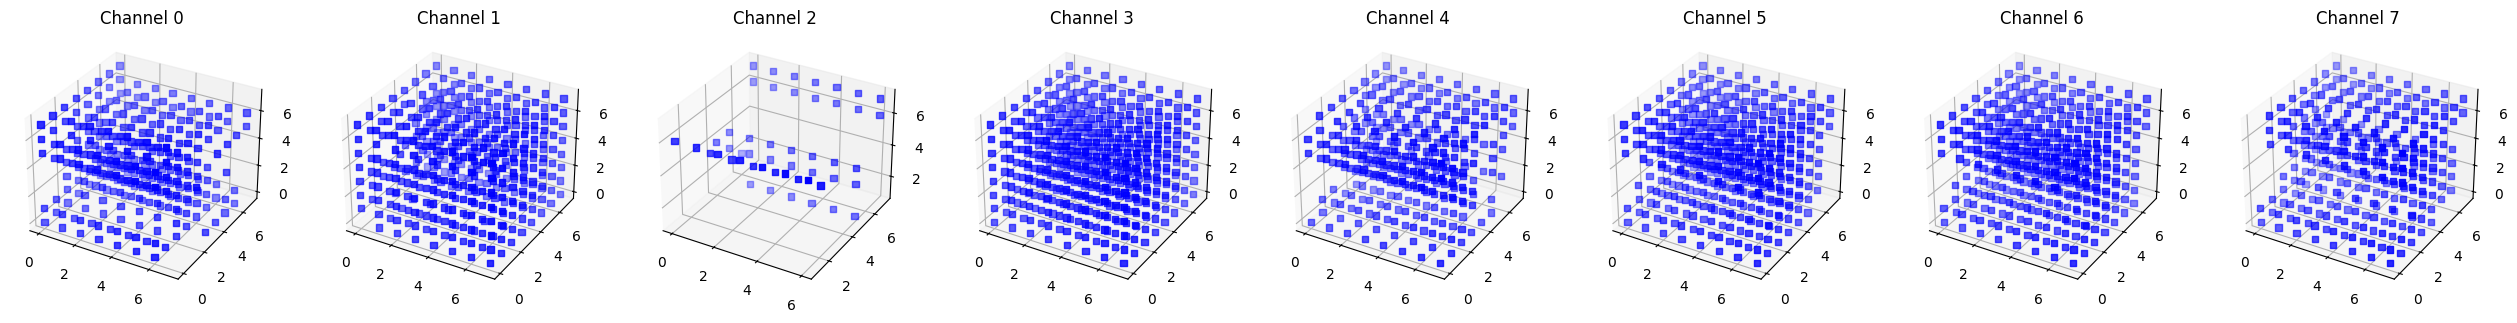

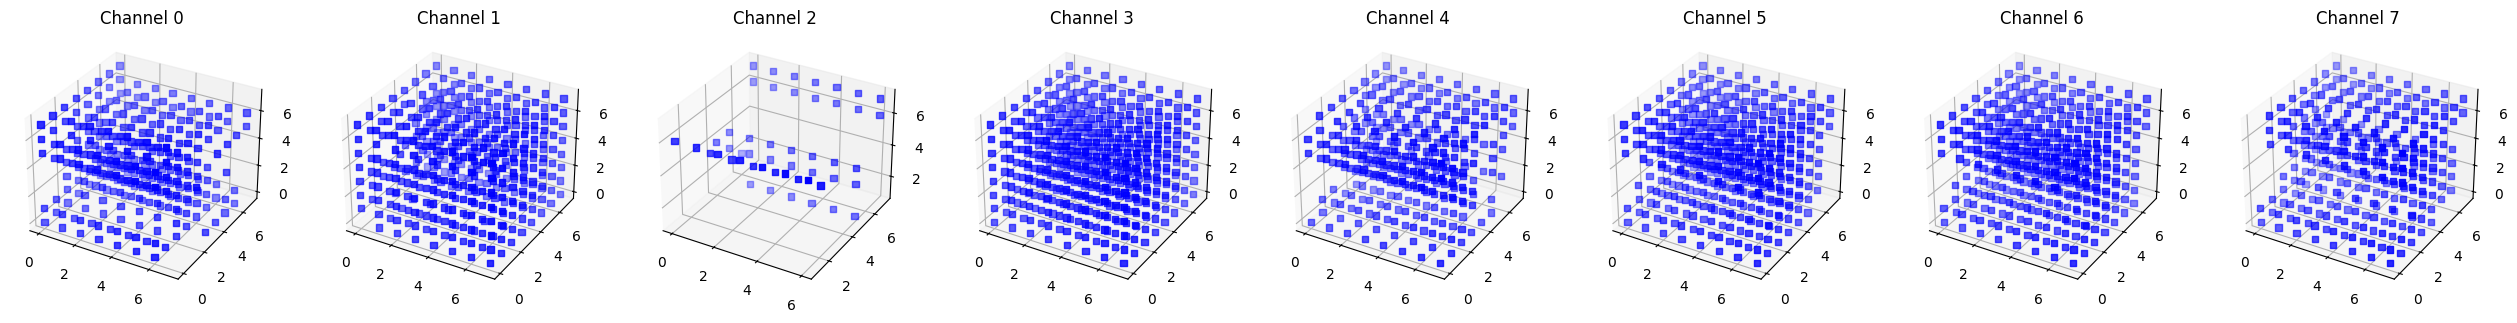

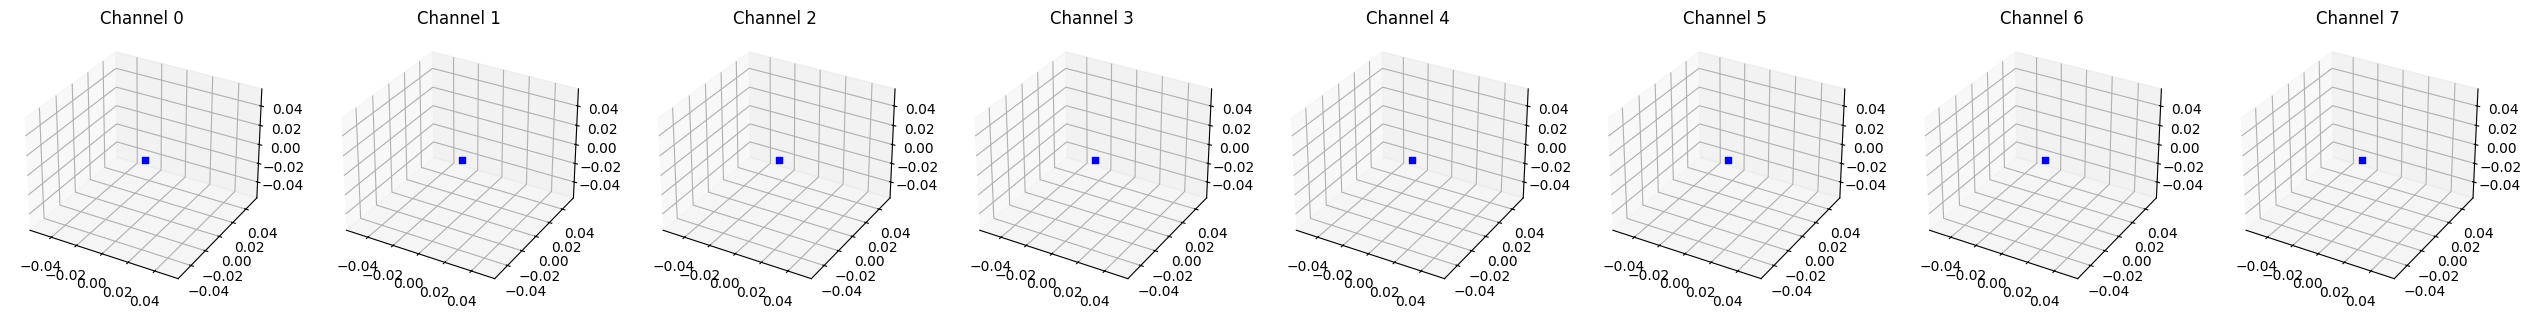

In [ ]:
def global_avg_pool3d(input_tensor):
    """Applies Global Average Pooling in 3D."""
    return torch.mean(input_tensor, dim=(2, 3, 4), keepdim=True)
def visualize_all_activation_maps(output_tensor):
    """Visualizes all activation map channels in separate subplots."""
    activation_map = output_tensor.detach().numpy().squeeze()

    # Ensure activation_map is at least 3D (C, D, H, W)
    if activation_map.ndim == 3:
        activation_map = np.expand_dims(activation_map, axis=0)  # Add channel axis

    num_channels = activation_map.shape[0]

    fig, axes = plt.subplots(1, num_channels, figsize=(num_channels * 4, 4), subplot_kw={'projection': '3d'})

    # Handle case where num_channels is 1 (avoid indexing issues)
    if num_channels == 1:
        axes = [axes]

    for i in range(num_channels):
        nonzero_voxels = np.argwhere(activation_map[i] > 0)
        if nonzero_voxels.size > 0 : #check to see if there are any voxels to visualize
            axes[i].scatter(nonzero_voxels[:, 0], nonzero_voxels[:, 1], nonzero_voxels[:, 2], c='b', marker='s')
        else: #if no nonzero voxels then plot a single point to show the output
            axes[i].scatter(0,0,0, c='b', marker='s')
        axes[i].set_title(f'Channel {i}')
    plt.show()
def compare_pooling_methods(output_tensor, kernel_size=2, stride=2):
    """Compares Max Pooling, Average Pooling, and Global Average Pooling on the given activation map."""
    pooled_max = max_pool3d(output_tensor, kernel_size, stride)
    pooled_avg = avg_pool3d(output_tensor, kernel_size, stride)
    pooled_global_avg = global_avg_pool3d(output_tensor)

    print("Max Pooled Shape:", pooled_max.shape)
    print("Avg Pooled Shape:", pooled_avg.shape)
    print("Global Avg Pooled Shape:", pooled_global_avg.shape)

    visualize_all_activation_maps(pooled_max.squeeze(0))
    visualize_all_activation_maps(pooled_avg.squeeze(0))
    visualize_all_activation_maps(pooled_global_avg.squeeze(0))
    num_points = 1000
points = np.random.rand(num_points, 3)

voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)


# Apply 3D convolution with custom parameters
output_tensor,_= apply_3d_convolution(voxel_tensor, out_channels=8, kernel_size=3, stride=1, padding=1, activation='relu')

# Compare pooling methods
compare_pooling_methods(output_tensor, kernel_size=2, stride=2)

changed activation function to tanh

Kernel Shape: torch.Size([8, 1, 3, 3, 3])
Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 8, 16, 16, 16])
Max Pooled Shape: torch.Size([1, 8, 8, 8, 8])
Avg Pooled Shape: torch.Size([1, 8, 8, 8, 8])
Global Avg Pooled Shape: torch.Size([1, 8, 1, 1, 1])


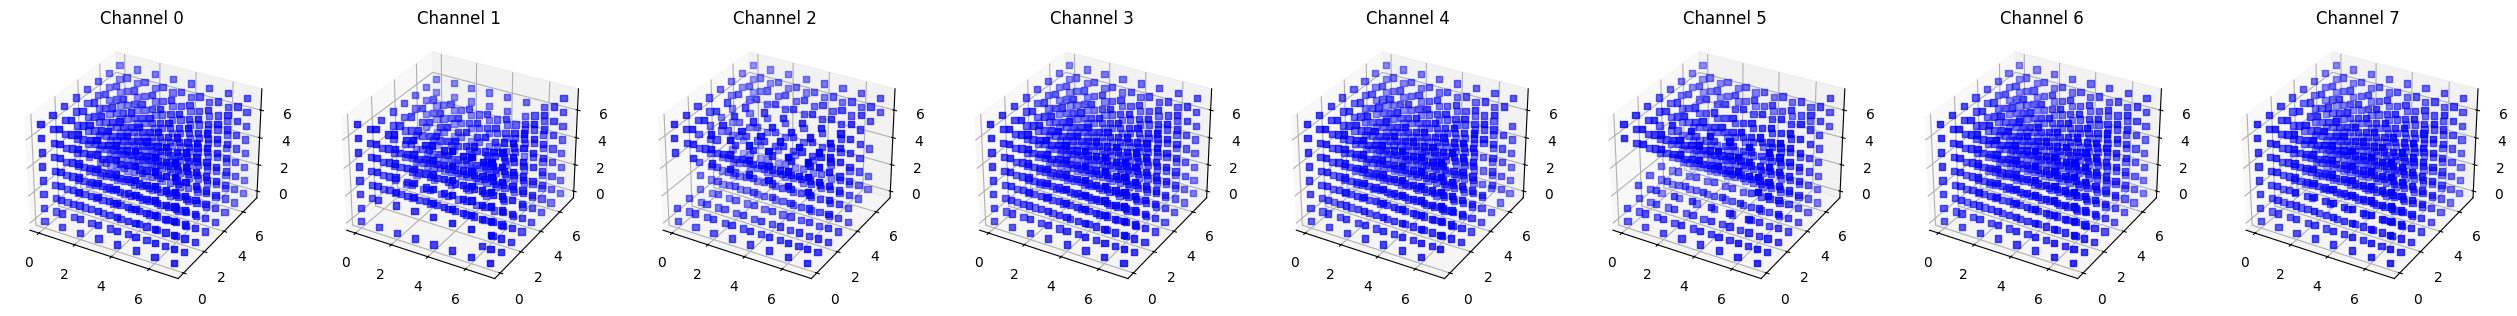

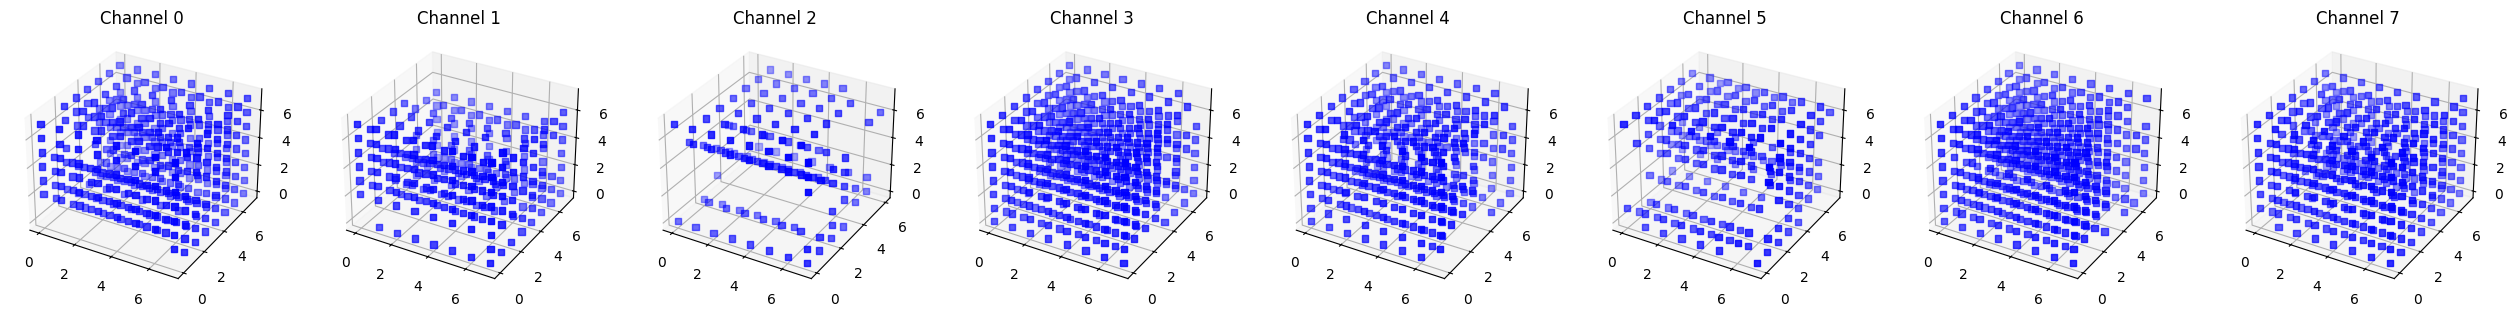

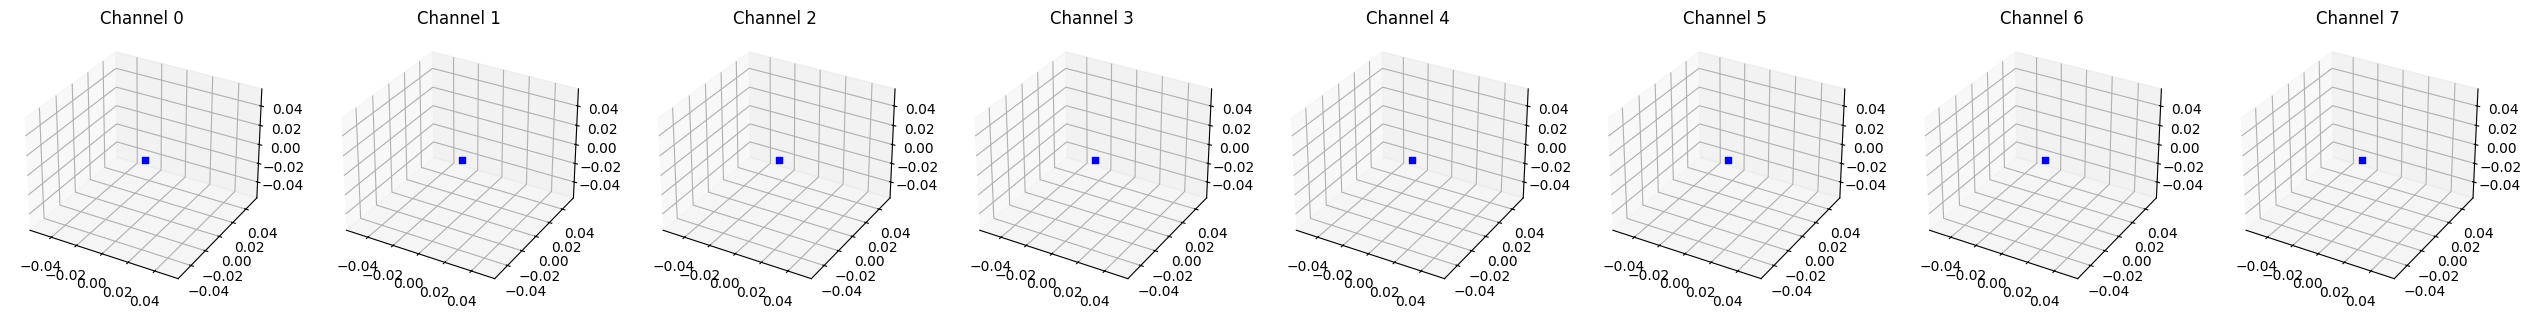

In [ ]:
voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)
output_tensor,_ = apply_3d_convolution(voxel_tensor, out_channels=8, kernel_size=3, stride=1, padding=1, activation='tanh')

# Compare pooling methods
compare_pooling_methods(output_tensor, kernel_size=2, stride=2)

Kernel Shape: torch.Size([8, 1, 3, 3, 3])
Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 8, 16, 16, 16])
MLP Output Shape: torch.Size([1, 10])


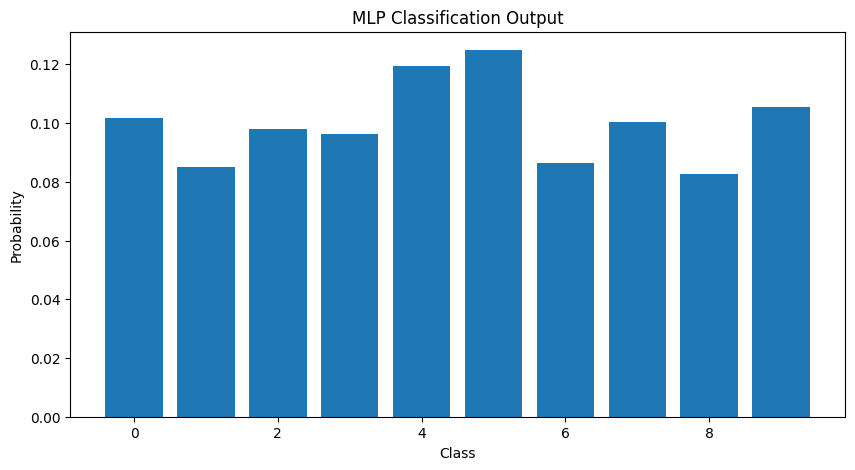

In [ ]:
import torch
import torch.nn as nn
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_layers=[128, 64], activation='relu', num_classes=10):
        super(MLPClassifier, self).__init__()
        layers = []
        in_dim = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        layers.append(nn.Softmax(dim=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage:
num_points = 1000
points = np.random.rand(num_points, 3)


# Apply 3D convolution with custom parameters
voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)
output_tensor,_= apply_3d_convolution(voxel_tensor, out_channels=8, kernel_size=3, stride=1, padding=1, activation='relu')

# Apply Global Average Pooling
gap_output = global_avg_pool3d(output_tensor)
flattened_output = gap_output.view(1, -1)

# Instantiate and apply MLP classifier
mlp = MLPClassifier(input_size=flattened_output.shape[1])
predictions = mlp(flattened_output)
print("MLP Output Shape:", predictions.shape)
plt.figure(figsize=(10, 5))
plt.bar(range(10), predictions.detach().numpy().flatten())
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("MLP Classification Output")
plt.show()

1 e) Everything all together

Kernel Shape: torch.Size([16, 1, 5, 5, 5])
Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 16, 12, 12, 12])
pooling layer1 shape torch.Size([1, 16, 6, 6, 6])
Kernel Shape: torch.Size([32, 16, 3, 3, 3])
Input Tensor Shape: torch.Size([1, 16, 6, 6, 6])
Output Tensor Shape: torch.Size([1, 32, 4, 4, 4])
pooling layer2 shape torch.Size([1, 32, 2, 2, 2])
MLP Output Shape: torch.Size([1, 10])


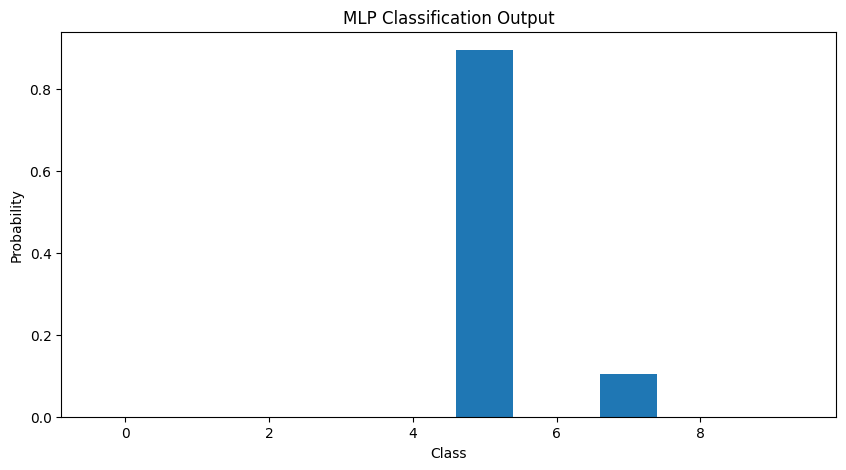

In [ ]:
num_points = 1000
points = np.random.rand(num_points, 3)
voxel_tensor = torch.tensor(voxel_sample).unsqueeze(0).unsqueeze(0)

# Apply 3D convolution to voxel tensor with 16 channels and kernel size 5*5*5
output_tensor,_= apply_3d_convolution(voxel_tensor, out_channels=16, kernel_size=5, stride=1, padding=0, activation='relu')

pooling1 = max_pool3d(output_tensor, kernel_size=2, stride=2)
print("pooling layer1 shape",pooling1.shape)
# pooling layer pass to convolution layer with kernel size 3 and total 32 channels
output_tensor2,_= apply_3d_convolution(pooling1, out_channels=32, kernel_size=3, stride=1, padding=0, activation='relu')
pooling2 = max_pool3d(output_tensor2, kernel_size=2, stride=2)
print("pooling layer2 shape",pooling2.shape)


gap_output = global_avg_pool3d(pooling2)
flattened_output = gap_output.view(1, -1)

# Instantiate and apply MLP classifier
mlp = MLPClassifier(input_size=flattened_output.shape[1]) # size is 1*32 after gap
predictions = mlp(flattened_output)
print("MLP Output Shape:", predictions.shape)
plt.figure(figsize=(10, 5))
plt.bar(range(10), predictions.detach().numpy().flatten())
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("MLP Classification Output")
plt.show()




In [ ]:
print(flattened_output.shape)

torch.Size([1, 32])


2) First created dataset then baseline then comapred elman from baseline , lstm vs baseline , GRU vs baseline

In [ ]:
# import random
# import string
# import csv
# import os
# from collections import deque

# def count_balanced_pairs(sequence):
#     """
#     Count balanced pairs of parentheses in a sequence using a stack-based approach.
#     Handles multiple types of brackets: (), {}, [], <>
#     """
#     stack = deque()
#     pair_count = 0
#     opening_brackets = {'(', '{', '[', '<'}
#     closing_brackets = {')', '}', ']', '>'}
#     bracket_pairs = {')': '(', '}': '{', ']': '[', '>': '<'}

#     for char in sequence:
#         if char in opening_brackets:
#             stack.append(char)
#         elif char in closing_brackets:
#             if not stack:
#                 # No matching opening bracket, ignore this closing bracket
#                 continue
#             last_open = stack.pop()
#             if last_open == bracket_pairs[char]:
#                 pair_count += 1
#             else:
#                 # Mismatched brackets, push the opening bracket back
#                 stack.append(last_open)

#     return pair_count

# def generate_random_sequence(min_length=10, max_length=100, balanced_probability=0.7):
#     """
#     Generate a random sequence with a mix of brackets, letters, digits, and punctuation.
#     Has a probability of generating balanced pairs.
#     """
#     length = random.randint(min_length, max_length)
#     brackets = ['(', ')', '{', '}', '[', ']', '<', '>']
#     other_chars = string.ascii_letters + string.digits + string.punctuation.replace(''.join(brackets), '')

#     sequence = []
#     stack = deque()  # Keep track of open brackets

#     for i in range(length):
#         # Decide what type of character to add
#         if random.random() < 0.35:  # 35% chance to add a bracket
#             if not stack or random.random() > balanced_probability:
#                 # Add an opening bracket
#                 open_bracket = random.choice(['(', '{', '[', '<'])
#                 sequence.append(open_bracket)
#                 stack.append(open_bracket)
#             else:
#                 # Add a corresponding closing bracket
#                 open_bracket = stack.pop()
#                 if open_bracket == '(':
#                     sequence.append(')')
#                 elif open_bracket == '{':
#                     sequence.append('}')
#                 elif open_bracket == '[':
#                     sequence.append(']')
#                 elif open_bracket == '<':
#                     sequence.append('>')
#         else:
#             # Add a non-bracket character
#             sequence.append(random.choice(other_chars))

#     return ''.join(sequence)

# def create_dataset(size=5000, output_file="parentheses_dataset.csv"):
#     """
#     Create a dataset of random sequences and their balanced pair counts.
#     """
#     dataset = []

#     # Generate sequences with varying degrees of balance
#     for i in range(size):
#         # Vary the probability of generating balanced pairs
#         balanced_prob = random.uniform(0.3, 0.9)
#         sequence = generate_random_sequence(balanced_probability=balanced_prob)
#         pair_count = count_balanced_pairs(sequence)
#         dataset.append((sequence, pair_count))

#         # Print progress
#         if (i + 1) % 500 == 0:
#             print(f"Generated {i + 1} sequences...")

#     # Write dataset to CSV file
#     with open(output_file, 'w', newline='', encoding='utf-8') as f:
#         writer = csv.writer(f)
#         writer.writerow(['sequence', 'balanced_pairs'])
#         writer.writerows(dataset)

#     print(f"Dataset with {size} samples created and saved to {output_file}")

#     # Print some statistics
#     pair_counts = [count for _, count in dataset]
#     avg_pairs = sum(pair_counts) / len(pair_counts)
#     max_pairs = max(pair_counts)
#     min_pairs = min(pair_counts)

#     print(f"Statistics:")
#     print(f"  Average balanced pairs: {avg_pairs:.2f}")
#     print(f"  Maximum balanced pairs: {max_pairs}")
#     print(f"  Minimum balanced pairs: {min_pairs}")

#     # Print distribution
#     distribution = {}
#     for _, count in dataset:
#         distribution[count] = distribution.get(count, 0) + 1

#     print("Distribution of balanced pairs:")
#     for count in sorted(distribution.keys()):
#         percentage = (distribution[count] / size) * 100
#         print(f"  {count} pairs: {distribution[count]} samples ({percentage:.2f}%)")

# def create_train_test_split(dataset_file, train_ratio=0.8):
#     """
#     Split the dataset into training and testing sets.
#     """
#     with open(dataset_file, 'r', newline='', encoding='utf-8') as f:
#         reader = csv.reader(f)
#         header = next(reader)
#         data = list(reader)

#     # Shuffle the data
#     random.shuffle(data)

#     # Split into train and test
#     split_point = int(len(data) * train_ratio)
#     train_data = data[:split_point]
#     test_data = data[split_point:]

#     # Write train data
#     train_file = dataset_file.replace('.csv', '_train.csv')
#     with open(train_file, 'w', newline='', encoding='utf-8') as f:
#         writer = csv.writer(f)
#         writer.writerow(header)
#         writer.writerows(train_data)

#     # Write test data
#     test_file = dataset_file.replace('.csv', '_test.csv')
#     with open(test_file, 'w', newline='', encoding='utf-8') as f:
#         writer = csv.writer(f)
#         writer.writerow(header)
#         writer.writerows(test_data)

#     print(f"Created training set with {len(train_data)} samples: {train_file}")
#     print(f"Created testing set with {len(test_data)} samples: {test_file}")

# def generate_examples_from_code_snippets():
#     """
#     Generate a small set of examples from code-like snippets to include in the dataset.
#     These are more realistic code-based examples.
#     """
#     code_snippets = [
#         "#include<iostream>",
#         "def calculate(x, y): return (x+y)*(x-y)",
#         "function main() { console.log('Hello {World}'); }",
#         "if (condition) { runCode(); } else { skipCode(); }",
#         "for(int i=0; i<10; i++) { array[i] = i*2; }",
#         "template<class T> void sort(T* begin, T* end);",
#         "std::vector<int> nums = {1, 2, 3, [4, 5], 6};",
#         "int main() { /* comment with (brackets) */ return 0; }",
#         "public List<String> getNames() { return new ArrayList<>(); }",
#         "matrix[row][col] = (value < threshold) ? max(value, 0) : {value};",
#         "try { riskyFunction(); } catch(Exception e) { handleError(e); }",
#         "@Deprecated(since=\"1.2\", forRemoval=true)"
#     ]

#     examples = []
#     for snippet in code_snippets:
#         pair_count = count_balanced_pairs(snippet)
#         examples.append((snippet, pair_count))
#         print(f"Example: '{snippet}' has {pair_count} balanced pairs")

#     return examples

# def main():
#     # Generate some code-like examples
#     print("Generating code snippet examples...")
#     code_examples = generate_examples_from_code_snippets()

#     # Create the main dataset
#     print("Creating main dataset...")
#     dataset_file = "parentheses_dataset.csv"
#     create_dataset(size=5500, output_file=dataset_file)

#     # Split into training and testing sets
#     print("Splitting into train and test sets...")
#     create_train_test_split(dataset_file)

#     print("Dataset generation complete!")

# if __name__ == "__main__":
#     main()



Baseline

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import string

# Define a dataset class for our parentheses data
class ParenthesesDataset(Dataset):
    def __init__(self, csv_file, max_length=100):
        self.data = pd.read_csv(csv_file)
        self.max_length = max_length

        # Create mappings for characters to integers
        self.char_to_idx = {
            '(': 0, ')': 1, '{': 2, '}': 3, '[': 4, ']': 5, '<': 6, '>': 7
        }
        # Add other characters as needed
        for i, char in enumerate(string.ascii_letters + string.digits + string.punctuation):
            if char not in self.char_to_idx:
                self.char_to_idx[char] = len(self.char_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data.iloc[idx]['sequence']
        balanced_pairs = self.data.iloc[idx]['balanced_pairs']

        # Convert sequence to numerical representation
        # We'll one-hot encode each character, focusing on brackets
        sequence_encoded = np.zeros((self.max_length, len(self.char_to_idx)), dtype=np.float32)
        for i, char in enumerate(sequence[:self.max_length]):
            if char in self.char_to_idx:
                sequence_encoded[i, self.char_to_idx[char]] = 1.0

        # Return tensor versions
        return {
            'sequence': torch.tensor(sequence_encoded, dtype=torch.float32),
            'length': min(len(sequence), self.max_length),
            'label': torch.tensor(balanced_pairs, dtype=torch.float32)
        }

# Baseline model class - always predicts 1
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

    def forward(self, x, lengths=None):
        # Return tensor of 1s with batch size
        batch_size = x.shape[0]
        return torch.ones(batch_size, 1, dtype=torch.float32, device=x.device)

# Function to evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            sequences = batch['sequence'].to(device)
            lengths = batch['length']
            labels = batch['label'].to(device).view(-1, 1)

            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.shape[0]

            predictions.extend(outputs.cpu().numpy().flatten())
            true_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)

    return avg_loss, mse, mae, predictions, true_labels

# Main function to run baseline evaluation
def run_baseline():
    import string  # Import here for the dataset class

    # Paths to your dataset files
    train_file = "/content/parentheses_dataset_train.csv"
    test_file = "/content/parentheses_dataset_test.csv"

    # Create datasets and data loaders
    train_dataset = ParenthesesDataset(train_file)
    test_dataset = ParenthesesDataset(test_file)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the baseline model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    baseline_model = BaselineModel().to(device)

    # Define loss function
    criterion = nn.MSELoss()

    # Evaluate baseline on training and test data
    train_loss, train_mse, train_mae, train_preds, train_labels = evaluate_model(
        baseline_model, train_loader, criterion, device
    )

    test_loss, test_mse, test_mae, test_preds, test_labels = evaluate_model(
        baseline_model, test_loader, criterion, device
    )

    # Print results
    print("Baseline Model Results:")
    print(f"Training - Loss: {train_loss:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
    print(f"Testing  - Loss: {test_loss:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")

    # Plot predictions vs true values for a sample of test data
    plt.figure(figsize=(10, 6))
    plt.scatter(test_labels[:100], test_preds[:100], alpha=0.5)
    plt.plot([0, max(test_labels)], [0, max(test_labels)], 'r--')
    plt.title("Baseline Model: Predicted vs True Values")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.savefig("baseline_predictions.png")
    plt.close()

    # Distribution of labels in test set
    plt.figure(figsize=(10, 6))
    plt.hist(test_labels, bins=20, alpha=0.7)
    plt.axvline(x=1, color='r', linestyle='--', label='Baseline Prediction (always 1)')
    plt.title("Distribution of Balanced Pairs in Test Set")
    plt.xlabel("Number of Balanced Pairs")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig("test_distribution.png")
    plt.close()

    return train_mse, test_mse

if __name__ == "__main__":
    train_mse, test_mse = run_baseline()
    print(f"Baseline MSE values - Train: {train_mse:.4f}, Test: {test_mse:.4f}")



Baseline Model Results:
Training - Loss: 63.0323, MSE: 63.0323, MAE: 6.5600
Testing  - Loss: 64.1109, MSE: 64.1109, MAE: 6.6327
Baseline MSE values - Train: 63.0323, Test: 64.1109


Training Custom Elman RNN Model...
Epoch 1, Loss: 31.0419
Epoch 2, Loss: 20.5619
Epoch 3, Loss: 20.5862
Epoch 4, Loss: 20.5568
Epoch 5, Loss: 20.5866
Epoch 6, Loss: 20.5706
Epoch 7, Loss: 20.5760
Epoch 8, Loss: 20.5787
Epoch 9, Loss: 20.5563
Epoch 10, Loss: 20.5770


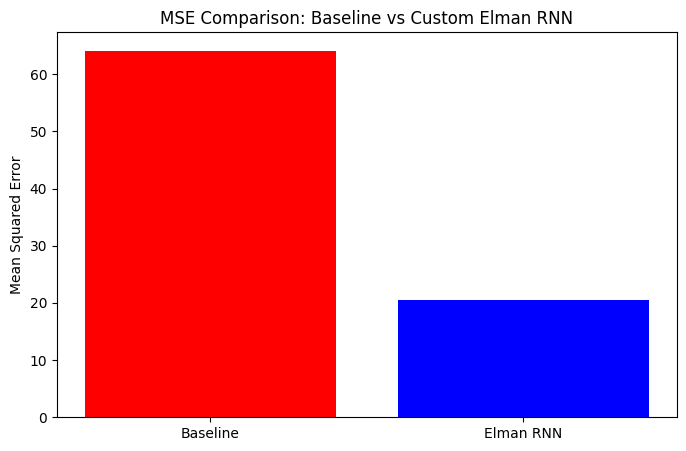

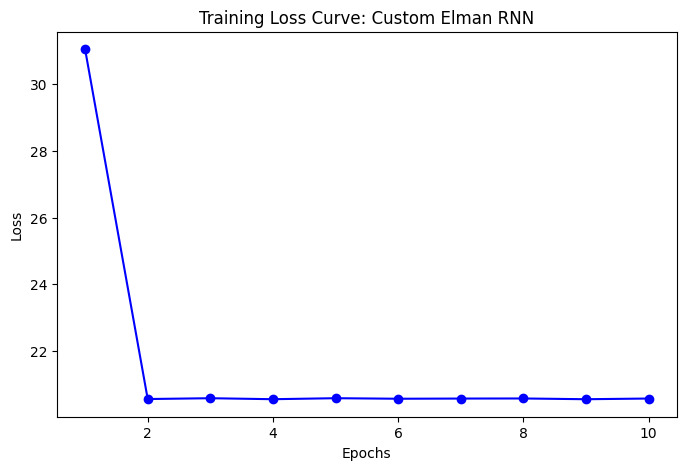

Baseline MSE: 64.1109
Custom Elman RNN MSE: 20.5527


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import string

# Define Custom Elman RNN model
class CustomElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Elman RNN parameters
        self.Wx = nn.Linear(input_size, hidden_size)
        self.Wh = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths=None):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t = torch.tanh(self.Wx(x_t) + self.Wh(h_t))

        out = self.fc(h_t)  # Output from last time step
        return out

# Function to train the Elman RNN model and store loss values
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in train_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * sequences.shape[0]

        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return model, loss_history

# Main function to train and compare Elman RNN with baseline
def run_comparison():
    train_file = "/content/parentheses_dataset_train.csv"
    test_file = "/content/parentheses_dataset_test.csv"

    train_dataset = ParenthesesDataset(train_file)
    test_dataset = ParenthesesDataset(test_file)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Baseline Model Evaluation
    baseline_model = BaselineModel().to(device)
    criterion = nn.MSELoss()

    _, baseline_test_mse, _, baseline_preds, test_labels = evaluate_model(
        baseline_model, test_loader, criterion, device
    )

    # Elman RNN Training and Evaluation
    input_size = len(train_dataset.char_to_idx)
    hidden_size = 64
    output_size = 1
    elman_model = CustomElmanRNN(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(elman_model.parameters(), lr=0.001)

    print("Training Custom Elman RNN Model...")
    elman_model, elman_loss_history = train_model(elman_model, train_loader, criterion, optimizer, device, epochs=10)

    elman_test_loss, elman_test_mse, _, elman_preds, _ = evaluate_model(elman_model, test_loader, criterion, device)

    # Compare MSE of Baseline and Elman RNN
    models = ["Baseline", "Elman RNN"]
    mse_values = [baseline_test_mse, elman_test_mse]

    plt.figure(figsize=(8, 5))
    plt.bar(models, mse_values, color=['red', 'blue'])
    plt.title("MSE Comparison: Baseline vs Custom Elman RNN")
    plt.ylabel("Mean Squared Error")
    plt.savefig("mse_comparison_elman.png")
    plt.show()

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), elman_loss_history, marker='o', linestyle='-', color='blue')
    plt.title("Training Loss Curve: Custom Elman RNN")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig("elman_learning_curve.png")
    plt.show()

    print(f"Baseline MSE: {baseline_test_mse:.4f}")
    print(f"Custom Elman RNN MSE: {elman_test_mse:.4f}")

if __name__ == "__main__":
    run_comparison()


LSTM vs baseline

Training Custom LSTM Model...
Epoch 1, Loss: 34.3688
Epoch 2, Loss: 20.5767
Epoch 3, Loss: 20.5793
Epoch 4, Loss: 20.5667
Epoch 5, Loss: 20.5882
Epoch 6, Loss: 20.5642
Epoch 7, Loss: 20.5796
Epoch 8, Loss: 20.6010
Epoch 9, Loss: 20.5992
Epoch 10, Loss: 20.5826


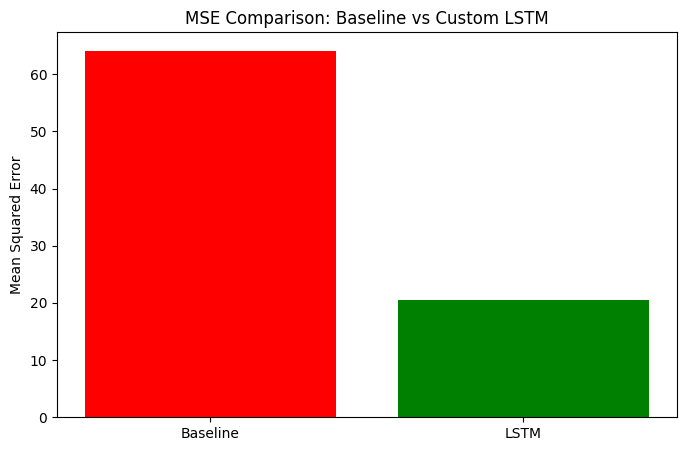

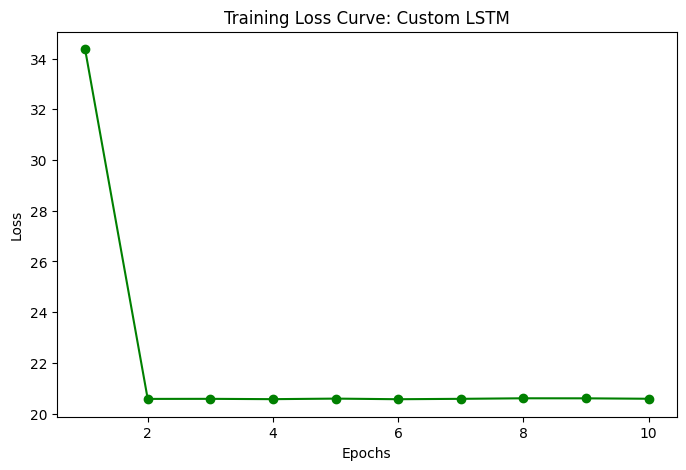

Baseline MSE: 64.1109
Custom LSTM MSE: 20.5543


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import string

# Define Custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # LSTM parameters
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wc = nn.Linear(input_size + hidden_size, hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths=None):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = torch.cat((x_t, h_t), dim=1)

            f_t = torch.sigmoid(self.Wf(combined))
            i_t = torch.sigmoid(self.Wi(combined))
            o_t = torch.sigmoid(self.Wo(combined))
            c_tilda = torch.tanh(self.Wc(combined))
            c_t = f_t * c_t + i_t * c_tilda
            h_t = o_t * torch.tanh(c_t)

        out = self.fc(h_t)  # Output from last time step
        return out

# Function to train the LSTM model and store loss values
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in train_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * sequences.shape[0]

        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return model, loss_history

# Main function to train and compare LSTM with baseline
def run_comparison():
    train_file = "/content/parentheses_dataset_train.csv"
    test_file = "/content/parentheses_dataset_test.csv"

    train_dataset = ParenthesesDataset(train_file)
    test_dataset = ParenthesesDataset(test_file)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Baseline Model Evaluation
    baseline_model = BaselineModel().to(device)
    criterion = nn.MSELoss()

    _, baseline_test_mse, _, baseline_preds, test_labels = evaluate_model(
        baseline_model, test_loader, criterion, device
    )

    # LSTM Training and Evaluation
    input_size = len(train_dataset.char_to_idx)
    hidden_size = 64
    output_size = 1
    lstm_model = CustomLSTM(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

    print("Training Custom LSTM Model...")
    lstm_model, lstm_loss_history = train_model(lstm_model, train_loader, criterion, optimizer, device, epochs=10)

    lstm_test_loss, lstm_test_mse, _, lstm_preds, _ = evaluate_model(lstm_model, test_loader, criterion, device)

    # Compare MSE of Baseline and LSTM
    models = ["Baseline", "LSTM"]
    mse_values = [baseline_test_mse, lstm_test_mse]

    plt.figure(figsize=(8, 5))
    plt.bar(models, mse_values, color=['red', 'green'])
    plt.title("MSE Comparison: Baseline vs Custom LSTM")
    plt.ylabel("Mean Squared Error")
    plt.savefig("mse_comparison_lstm.png")
    plt.show()

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), lstm_loss_history, marker='o', linestyle='-', color='green')
    plt.title("Training Loss Curve: Custom LSTM")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig("lstm_learning_curve.png")
    plt.show()

    print(f"Baseline MSE: {baseline_test_mse:.4f}")
    print(f"Custom LSTM MSE: {lstm_test_mse:.4f}")

if __name__ == "__main__":
    run_comparison()


GRU VS Baseline

Training Custom GRU Model...
Epoch 1, Loss: 32.8784
Epoch 2, Loss: 20.5139
Epoch 3, Loss: 20.2358
Epoch 4, Loss: 17.5701
Epoch 5, Loss: 6.4771
Epoch 6, Loss: 4.6928
Epoch 7, Loss: 3.3274
Epoch 8, Loss: 2.7393
Epoch 9, Loss: 2.4934
Epoch 10, Loss: 2.5772


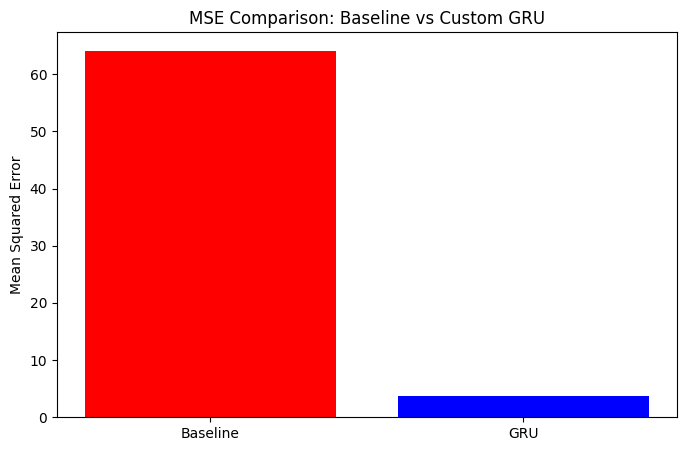

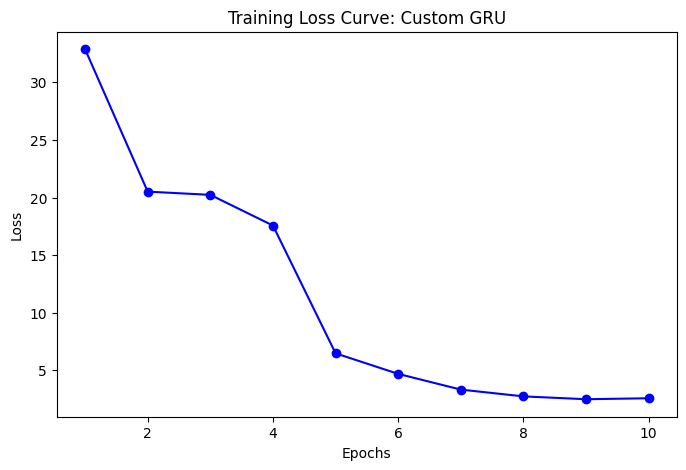

Baseline MSE: 64.1109
Custom GRU MSE: 3.7015


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import string

# Define Custom GRU model
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # GRU parameters
        self.Wz = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wr = nn.Linear(input_size + hidden_size, hidden_size)
        self.Wh = nn.Linear(input_size + hidden_size, hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths=None):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = torch.cat((x_t, h_t), dim=1)

            z_t = torch.sigmoid(self.Wz(combined))
            r_t = torch.sigmoid(self.Wr(combined))
            h_tilda = torch.tanh(self.Wh(torch.cat((x_t, r_t * h_t), dim=1)))
            h_t = (1 - z_t) * h_t + z_t * h_tilda

        out = self.fc(h_t)  # Output from last time step
        return out

# Function to train the GRU model and store loss values
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in train_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * sequences.shape[0]

        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return model, loss_history

# Main function to train and compare GRU with baseline
def run_comparison():
    train_file = "/content/parentheses_dataset_train.csv"
    test_file = "/content/parentheses_dataset_test.csv"

    train_dataset = ParenthesesDataset(train_file)
    test_dataset = ParenthesesDataset(test_file)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Baseline Model Evaluation
    baseline_model = BaselineModel().to(device)
    criterion = nn.MSELoss()

    _, baseline_test_mse, _, baseline_preds, test_labels = evaluate_model(
        baseline_model, test_loader, criterion, device
    )

    # GRU Training and Evaluation
    input_size = len(train_dataset.char_to_idx)
    hidden_size = 64
    output_size = 1
    gru_model = CustomGRU(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

    print("Training Custom GRU Model...")
    gru_model, gru_loss_history = train_model(gru_model, train_loader, criterion, optimizer, device, epochs=10)

    gru_test_loss, gru_test_mse, _, gru_preds, _ = evaluate_model(gru_model, test_loader, criterion, device)

    # Compare MSE of Baseline and GRU
    models = ["Baseline", "GRU"]
    mse_values = [baseline_test_mse, gru_test_mse]

    plt.figure(figsize=(8, 5))
    plt.bar(models, mse_values, color=['red', 'blue'])
    plt.title("MSE Comparison: Baseline vs Custom GRU")
    plt.ylabel("Mean Squared Error")
    plt.savefig("mse_comparison.png")
    plt.show()

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), gru_loss_history, marker='o', linestyle='-', color='blue')
    plt.title("Training Loss Curve: Custom GRU")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig("gru_learning_curve.png")
    plt.show()

    print(f"Baseline MSE: {baseline_test_mse:.4f}")
    print(f"Custom GRU MSE: {gru_test_mse:.4f}")

if __name__ == "__main__":
    run_comparison()
